# Feature Selection Pipeline: IV + Correlation + Lasso LR + Random Forest

This notebook performs a two-step feature selection on the cleaned dataset:

- Step 1 – Univariate Filtering
  - Use precomputed Information Value (IV) to drop features with IV < 0.02
  - Drop highly correlated features (|corr| > 0.8) on WOE-encoded features
- Step 2 – Model-Based Selection
  - Lasso Logistic Regression to select top 15 variables by non-zero coefficients
  - Random Forest to select top 15 variables by feature importance
  - Compare overlap and select final top ≤15 variables to predict default (TARGET)


In [8]:
# Imports and setup
import json
import math
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore")

DATA_PATH = Path("merged_applicant_and_bureau_cleaned.csv")
IV_SUMMARY_PATH = Path("woe_iv_outputs/woe_iv_summary.csv")
BIN_SPECS_PATH = Path("woe_iv_outputs/woe_bin_specs.json")
OUTPUT_DIR = Path("model_data")
OUTPUT_DIR.mkdir(exist_ok=True)

TARGET_COL = "TARGET"
IV_THRESHOLD = 0.02
CORR_THRESHOLD = 0.8
TOP_K = 15

# Load data
_df = pd.read_csv(DATA_PATH)
assert TARGET_COL in _df.columns, f"Target column '{TARGET_COL}' not found in dataset."

y = _df[TARGET_COL].astype(int)
print({"rows": len(_df), "positive_rate": float(y.mean())})

{'rows': 254358, 'positive_rate': 0.07612498918846665}


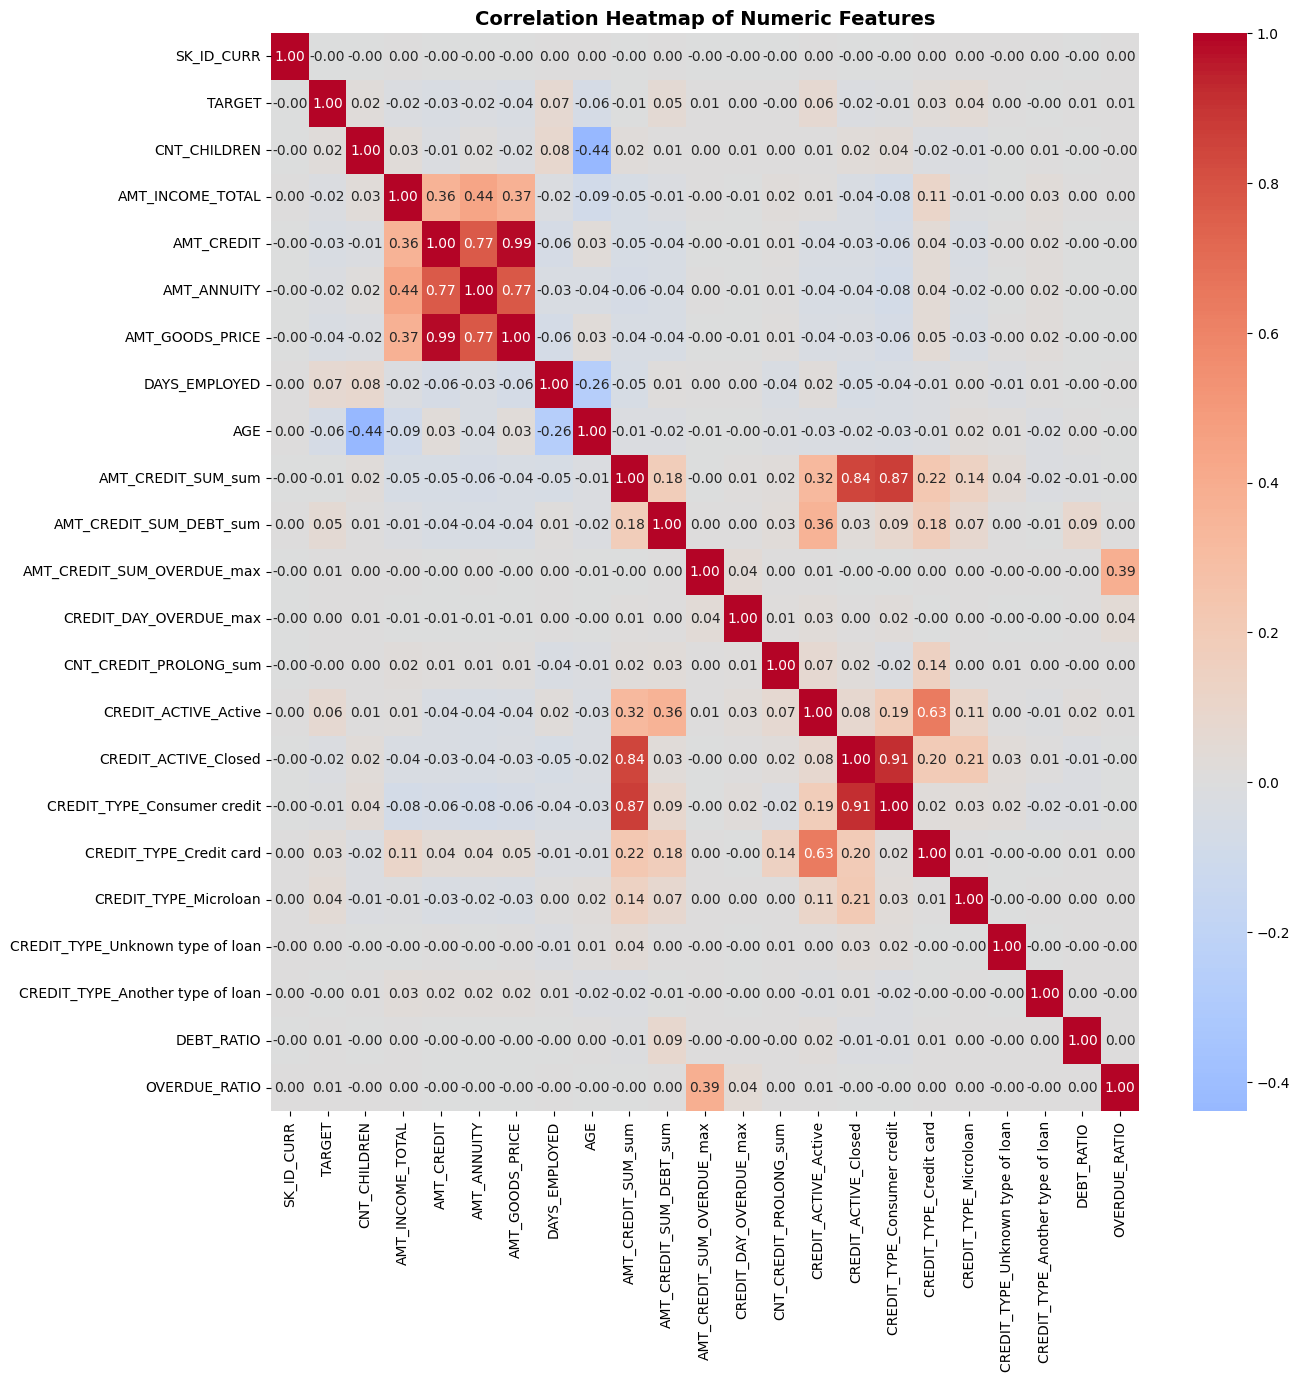

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for numeric columns
corr_matrix = _df.select_dtypes(include=['number']).corr()

# Plot heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features", fontsize=14, fontweight='bold')
plt.show()


In [23]:
# WOE binning + IV computation utilities using provided bin specs

with open(BIN_SPECS_PATH, "r") as f:
    BIN_SPECS = json.load(f)

FEATURES_IN_SPEC = list(BIN_SPECS.keys())
features_available = [c for c in FEATURES_IN_SPEC if c in _df.columns]
print({"features_in_spec": len(FEATURES_IN_SPEC), "available": len(features_available)})

alpha = 0.5


def _bin_series_numeric(s: pd.Series, edges: list, has_missing: bool) -> pd.Series:
    edges = list(edges)
    binned = pd.cut(s, bins=edges, include_lowest=True, right=True, duplicates="drop")
    if has_missing:
        return binned.astype(object).where(~s.isna(), other="MISSING")
    else:
        return binned


def _bin_series_categorical(s: pd.Series, levels: list, has_missing: bool) -> pd.Series:
    levels_set = set(levels or [])
    has_other = "OTHER" in levels_set
    def map_cat(v):
        if pd.isna(v) and has_missing:
            return "MISSING"
        if v in levels_set:
            return v
        return "OTHER" if has_other else v
    return s.map(map_cat)


def compute_woe_map_for_feature(df: pd.DataFrame, feature: str, y: pd.Series):
    spec = BIN_SPECS.get(feature)
    if spec is None:
        return None, None
    ftype = spec.get("type")
    has_missing = bool(spec.get("has_missing"))

    s = df[feature]
    if ftype.startswith("numeric"):
        edges = spec.get("quantiles")
        s_b = _bin_series_numeric(s, edges, has_missing)
    elif ftype.startswith("categorical"):
        levels = spec.get("levels")
        s_b = _bin_series_categorical(s, levels, has_missing)
    else:
        return None, None

    good_total = (y == 0).sum()
    bad_total = (y == 1).sum()
    grp = pd.DataFrame({"bin": s_b, "y": y}).groupby("bin", dropna=False)
    stats = grp["y"].agg(["count", "sum"]).rename(columns={"sum": "bad"})
    stats["good"] = stats["count"] - stats["bad"]

    n_bins = len(stats)
    stats["dist_good"] = (stats["good"] + alpha) / (good_total + alpha * n_bins)
    stats["dist_bad"] = (stats["bad"] + alpha) / (bad_total + alpha * n_bins)
    stats["woe"] = np.log(stats["dist_good"] / stats["dist_bad"])  # good vs bad
    stats["iv_contrib"] = (stats["dist_good"] - stats["dist_bad"]) * stats["woe"]
    iv = float(stats["iv_contrib"].sum())
    woe_map = stats["woe"].to_dict()
    s_woe = s_b.map(woe_map)
    return s_woe, iv

X_woe = pd.DataFrame(index=_df.index)
computed_iv = {}
for feat in features_available:
    s_woe, iv = compute_woe_map_for_feature(_df, feat, y)
    if s_woe is not None:
        X_woe[feat] = s_woe
        computed_iv[feat] = iv

print({"woe_features": X_woe.shape[1]})

iv_df_file = pd.read_csv(IV_SUMMARY_PATH) if IV_SUMMARY_PATH.exists() else pd.DataFrame(columns=["variable", "IV"])
iv_df_comp = pd.DataFrame({"variable": list(computed_iv.keys()), "IV": list(computed_iv.values())})

iv_df = iv_df_comp.merge(iv_df_file, on="variable", how="outer", suffixes=("_comp", "_file"))
iv_df["IV_final"] = iv_df["IV_file"].fillna(iv_df["IV_comp"]).fillna(0.0)
iv_df = iv_df[["variable", "IV_final"]].rename(columns={"IV_final": "IV"}).sort_values("IV", ascending=False)

iv_df.head(15)


{'features_in_spec': 26, 'available': 26}
{'woe_features': 26}


,variable,IV
18,DAYS_EMPLOYED,0.091306
19,DEBT_RATIO,0.077947
3,AMT_CREDIT_SUM_DEBT_sum,0.076850
24,OCCUPATION_TYPE,0.067540
0,AGE,0.054176
10,CREDIT_ACTIVE_Active,0.045366
23,NAME_INCOME_TYPE,0.039106
2,AMT_CREDIT,0.037432
6,AMT_GOODS_PRICE,0.031239
1,AMT_ANNUITY,0.025038


In [24]:
# Step 1 – Univariate filtering (IV threshold) and correlation pruning with explanations

kept_by_iv = iv_df[iv_df["IV"] >= IV_THRESHOLD]["variable"].tolist()
print(f"Kept by IV (>= {IV_THRESHOLD}): {len(kept_by_iv)} features")

X_iv = X_woe[kept_by_iv].copy()
abs_corr = X_iv.corr().abs()

# Order variables by IV descending (most predictive first)
order = iv_df.set_index("variable").loc[kept_by_iv].sort_values("IV", ascending=False).index.tolist()

kept = []
skipped = []
drop_reasons = []  # store tuples (dropped_feature, correlated_with, corr_value)

for f in order:
    if kept:  # compare with already-kept features
        corr_with_kept = abs_corr.loc[f, kept].abs()
        max_corr = corr_with_kept.max()
        most_corr_feat = corr_with_kept.idxmax()

        # Drop feature if correlation exceeds threshold
        if pd.notna(max_corr) and max_corr > CORR_THRESHOLD:
            skipped.append(f)
            drop_reasons.append((f, most_corr_feat, round(max_corr, 3)))
            continue
    kept.append(f)

# Summary
print(f"\nAfter correlation filtering:")
print(f" - Kept: {len(kept)} features")
print(f" - Removed due to correlation: {len(kept_by_iv) - len(kept)} features\n")

# Show which were dropped and why
if drop_reasons:
    drop_df = pd.DataFrame(drop_reasons, columns=["Dropped Feature", "Correlated With", "Correlation"])
    display(drop_df)
else:
    print("No features were dropped due to correlation.")

# Final filtered set
X_flt = X_iv[kept].copy()
X_flt.describe().T.head(10)


Kept by IV (>= 0.02): 10 features

After correlation filtering:
 - Kept: 8 features
 - Removed due to correlation: 2 features



,Dropped Feature,Correlated With,Correlation
0,AMT_CREDIT_SUM_DEBT_sum,DEBT_RATIO,0.953
1,AMT_GOODS_PRICE,AMT_CREDIT,0.841


,count,mean,std,min,25%,50%,75%,max
DAYS_EMPLOYED,254358.0,0.039904,0.307332,-0.550124,-0.292711,0.170068,0.325382,0.459296
DEBT_RATIO,254358.0,0.017973,0.199149,-0.470519,-0.015189,-0.015189,0.163550,0.163550
OCCUPATION_TYPE,254358.0,0.030665,0.268632,-0.384396,-0.289569,0.190935,0.245510,0.555298
CREDIT_ACTIVE_Active,254358.0,0.006854,0.123016,-0.389190,-0.015189,0.079692,0.079692,0.079692
NAME_INCOME_TYPE,254358.0,0.020173,0.220723,-2.496011,-0.176701,-0.176701,0.327986,0.937977
AMT_ANNUITY,254358.0,0.009241,0.148455,-0.886596,-0.086849,-0.077607,0.160017,0.448405


In [11]:
print(kept_by_iv)

['DAYS_EMPLOYED', 'DEBT_RATIO', 'AMT_CREDIT_SUM_DEBT_sum', 'OCCUPATION_TYPE', 'AGE', 'CREDIT_ACTIVE_Active', 'NAME_INCOME_TYPE', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY']


In [12]:
# Step 2 – Model-Based Selection (Lasso Logistic Regression and Random Forest)

# Lasso Logistic Regression for feature selection
X = X_flt.values
feature_names = list(X_flt.columns)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lasso = LogisticRegressionCV(
    Cs=np.logspace(-3, 3, 15),
    cv=cv,
    penalty='l1',
    solver='saga',
    scoring='roc_auc',
    max_iter=5000,
    n_jobs=-1,
    refit=True,
)
lasso.fit(X, y)
coefs = lasso.coef_.ravel()
coef_abs = np.abs(coefs)

lasso_selected_idx = np.where(coef_abs > 1e-6)[0]
lasso_ranked = sorted([(feature_names[i], coef_abs[i]) for i in range(len(feature_names))], key=lambda x: x[1], reverse=True)
lasso_top = [f for f, v in lasso_ranked[:TOP_K] if v > 0]


# Random Forest Classification for feature importance 
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)
rf.fit(X, y)
rf_importance = rf.feature_importances_
rf_ranked = sorted([(feature_names[i], rf_importance[i]) for i in range(len(feature_names))], key=lambda x: x[1], reverse=True)
rf_top = [f for f, v in rf_ranked[:TOP_K] if v > 0]

print({
    "lasso_nonzero": int((coef_abs > 1e-6).sum()),
    "lasso_top_len": len(lasso_top),
    "rf_top_len": len(rf_top),
    "overlap": len(set(lasso_top) & set(rf_top)),
})
ranks_lasso = {f: i+1 for i, (f, v) in enumerate(lasso_ranked)}
ranks_rf = {f: i+1 for i, (f, v) in enumerate(rf_ranked)}
all_feats = list(dict.fromkeys([*feature_names]))

comp_rows = []
for f in all_feats:
    comp_rows.append({
        "feature": f,
        "lasso_rank": ranks_lasso.get(f, np.nan),
        "rf_rank": ranks_rf.get(f, np.nan),
        "in_lasso_top": f in lasso_top,
        "in_rf_top": f in rf_top,
    })
comp_df = pd.DataFrame(comp_rows)
comp_df["avg_rank"] = comp_df[["lasso_rank", "rf_rank"]].mean(axis=1)
comp_df.sort_values(["in_lasso_top", "in_rf_top", "avg_rank"], ascending=[False, False, True]).head(20)


{'lasso_nonzero': 8, 'lasso_top_len': 8, 'rf_top_len': 8, 'overlap': 8}


,feature,lasso_rank,rf_rank,in_lasso_top,in_rf_top,avg_rank
2,OCCUPATION_TYPE,4,1,True,True,2.5
0,DAYS_EMPLOYED,3,4,True,True,3.5
6,AMT_CREDIT,2,5,True,True,3.5
1,DEBT_RATIO,1,7,True,True,4.0
7,AMT_ANNUITY,5,3,True,True,4.0
3,AGE,7,2,True,True,4.5
4,CREDIT_ACTIVE_Active,6,8,True,True,7.0
5,NAME_INCOME_TYPE,8,6,True,True,7.0


In [13]:
# Final selection: consensus and save artifacts

lasso_set = set(lasso_top)
rf_set = set(rf_top)
intersection = list(lasso_set & rf_set)
union = list(lasso_set | rf_set)
remaining_needed = max(0, TOP_K - len(intersection))

if remaining_needed > 0:
    union_ranks = []
    for f in union:
        lr = next((i+1 for i, (n, _) in enumerate(lasso_ranked) if n == f), np.inf)
        rr = next((i+1 for i, (n, _) in enumerate(rf_ranked) if n == f), np.inf)
        union_ranks.append((f, np.nanmean([lr, rr])))
    union_ranks = [(f, r) for f, r in union_ranks if f not in intersection]
    union_ranks.sort(key=lambda x: x[1])
    fillers = [f for f, r in union_ranks[:remaining_needed]]
else:
    fillers = []

final_features = intersection + fillers
final_features = final_features[:TOP_K]

print({
    "intersection": len(intersection),
    "final_selected": len(final_features),
})

sel_path = OUTPUT_DIR / "selected_features_top15.csv"
pd.DataFrame({"feature": final_features}).to_csv(sel_path, index=False)
print(f"Saved: {sel_path}")

model_df = pd.concat([X_woe[final_features], y.rename(TARGET_COL)], axis=1)
model_path = OUTPUT_DIR / "model_features_woe_selected.csv"
model_df.to_csv(model_path, index=False)
print(f"Saved: {model_path} (shape={model_df.shape})")

comp_summary = comp_df.set_index("feature").loc[final_features][["lasso_rank", "rf_rank", "avg_rank"]]
comp_summary


{'intersection': 8, 'final_selected': 8}
Saved: model_data\selected_features_top15.csv
Saved: model_data\model_features_woe_selected.csv (shape=(254358, 9))


,lasso_rank,rf_rank,avg_rank
feature,,,
DEBT_RATIO,1,7,4.0
AMT_ANNUITY,5,3,4.0
NAME_INCOME_TYPE,8,6,7.0
AMT_CREDIT,2,5,3.5
AGE,7,2,4.5
OCCUPATION_TYPE,4,1,2.5
CREDIT_ACTIVE_Active,6,8,7.0
DAYS_EMPLOYED,3,4,3.5


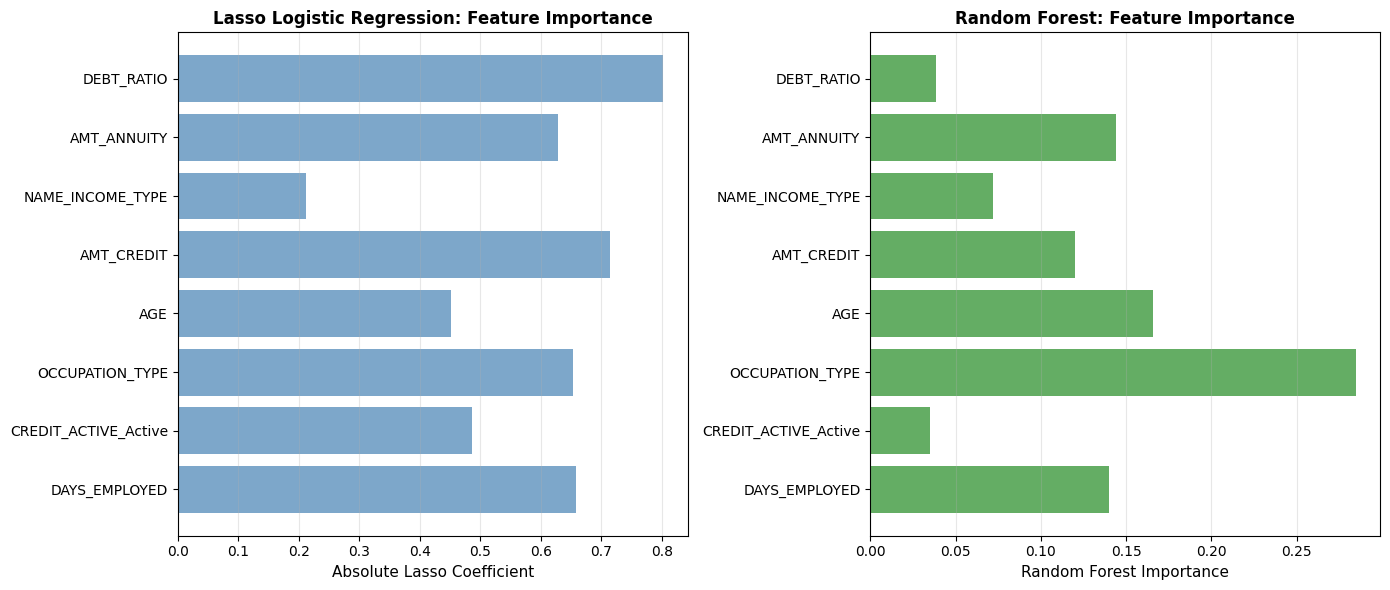

In [14]:
# Visualize Lasso vs Random Forest feature rankings
import matplotlib.pyplot as plt

viz_features = final_features[:15]
lasso_vals = [next((v for f, v in lasso_ranked if f == feat), 0) for feat in viz_features]
rf_vals = [next((v for f, v in rf_ranked if f == feat), 0) for feat in viz_features]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.barh(viz_features, lasso_vals, color='steelblue', alpha=0.7)
ax1.set_xlabel('Absolute Lasso Coefficient', fontsize=11)
ax1.set_title('Lasso Logistic Regression: Feature Importance', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

ax2.barh(viz_features, rf_vals, color='forestgreen', alpha=0.7)
ax2.set_xlabel('Random Forest Importance', fontsize=11)
ax2.set_title('Random Forest: Feature Importance', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


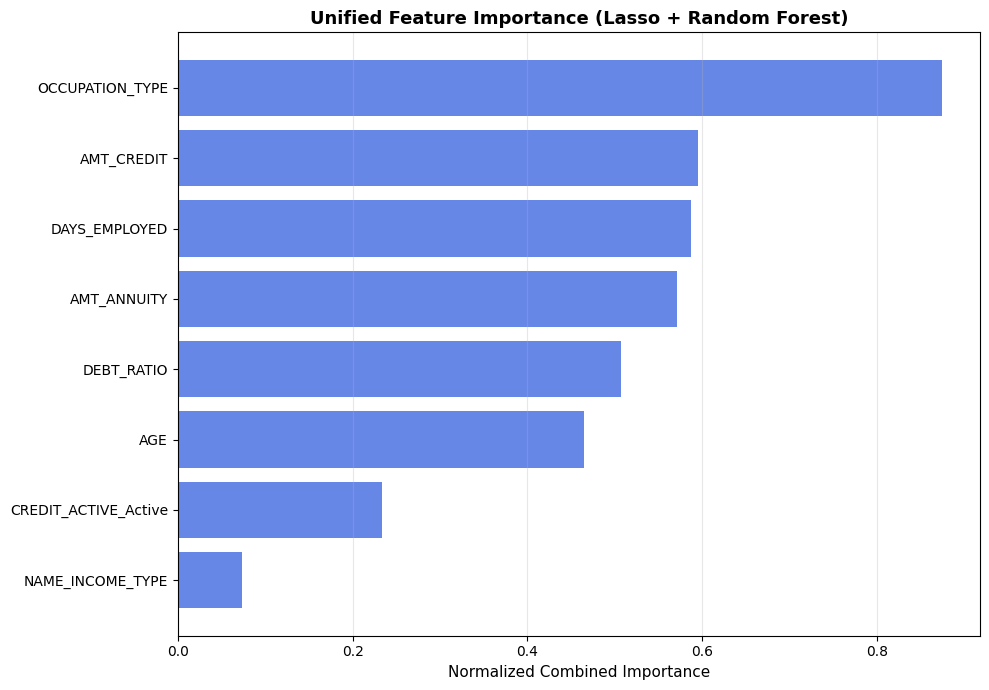

,Feature,Lasso,RandomForest,Combined
5,OCCUPATION_TYPE,0.748394,1.000000,0.874197
3,AMT_CREDIT,0.852385,0.338751,0.595568
7,DAYS_EMPLOYED,0.756077,0.419392,0.587734
1,AMT_ANNUITY,0.705679,0.436378,0.571029
0,DEBT_RATIO,1.000000,0.014074,0.507037
4,AGE,0.405925,0.522825,0.464375
6,CREDIT_ACTIVE_Active,0.466195,0.000000,0.233097
2,NAME_INCOME_TYPE,0.000000,0.147732,0.073866


In [15]:
# Unified Feature Importance Visualization (Weighted Combination)

# --- Prepare data ---
viz_features = final_features[:15]
lasso_vals = [next((v for f, v in lasso_ranked if f == feat), 0) for feat in viz_features]
rf_vals = [next((v for f, v in rf_ranked if f == feat), 0) for feat in viz_features]

# --- Normalize both sets of importances to [0, 1] ---
lasso_norm = (np.array(lasso_vals) - np.min(lasso_vals)) / (np.max(lasso_vals) - np.min(lasso_vals) + 1e-9)
rf_norm = (np.array(rf_vals) - np.min(rf_vals)) / (np.max(rf_vals) - np.min(rf_vals) + 1e-9)

# --- Combine (average) the normalized scores ---
combined_importance = (lasso_norm + rf_norm) / 2

# --- Create a DataFrame for sorting and visualization ---
importance_df = pd.DataFrame({
    'Feature': viz_features,
    'Lasso': lasso_norm,
    'RandomForest': rf_norm,
    'Combined': combined_importance
}).sort_values(by='Combined', ascending=False)

# --- Plot combined ranking ---
plt.figure(figsize=(10, 7))
plt.barh(importance_df['Feature'], importance_df['Combined'], color='royalblue', alpha=0.8)
plt.xlabel('Normalized Combined Importance', fontsize=11)
plt.title('Unified Feature Importance (Lasso + Random Forest)', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_importance_combined_weighted.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Optional: display the top combined features ---
display(importance_df.head(15))
